In [1]:
from numpy import array
import numpy as np
import pandas as pd
from numpy import array

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
import pickle

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


In [2]:
def predict_1dcnn(model,input,r_data,scaler,look_back=8,s=4):
    size=r_data.size
    predicted_1y=[]
    for i in range(size):
        #print(input)
        input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
        input_lstm=np.reshape(input_lstm, (1,s,2,1))
        #print(input_lstm)
        y=model.predict(input_lstm,verbose=0)
        x=scaler.transform([r_data[i]])
        input=np.append(input,x)
        y=scaler.inverse_transform(y)
        predicted_1y.append(y[0])
        #print(predicted_y)
        #i=i+1

    return predicted_1y

In [3]:
def predict_1mcnn(model,input,r_data,scaler,look_back=8,s=4):
    size=r_data.size
    predicted_1y=[]
    for i in range(size):
        #print(input)
        input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
        input_lstm=np.reshape(input_lstm, (1,s,2,1))
        #print(input_lstm)
        y=model.predict(input_lstm,verbose=0)
        input=np.append(input,y[0])
        y=scaler.inverse_transform(y)
        predicted_1y.append(y[0])
        #print(predicted_y)
        #i=i+1

    return predicted_1y

In [4]:
def predict_1m(model,input,r_data,scaler,look_back=8):
    size=r_data.size
    predicted_y=[]
    for i in range(size):
        #print(input)
        input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
        input_lstm=np.reshape(input_lstm, (1,look_back,1))
        #print(input_lstm)
        y=model.predict(input_lstm,verbose=0)
        #print(y)
        input=np.append(input,y[0])
        y=scaler.inverse_transform(y)
        predicted_y.append(y[0])
        #print(predicted_y)
        #i=i+1

    return predicted_y

In [5]:
def predict_1d(model,input,r_data,scaler,look_back=8):
    size=r_data.size
    predicted_1y=[]
    for i in range(size):
        #print(input)
        input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
        input_lstm=np.reshape(input_lstm, (1,look_back,1))
        #print(input_lstm)
        y=model.predict(input_lstm,verbose=0)
        #print(y)
        x=scaler.transform([r_data[i]])
        input=np.append(input,x)
        y=scaler.inverse_transform(y)
        predicted_1y.append(y[0])
        #print(predicted_y)
        #i=i+1

    return predicted_1y
    

In [6]:
def create_dataframe(x,r_data,a_price):
    l=r_data.size
    date=a_price['Date']
    date=date.tail(l)
    p=pd.DataFrame(x,index=date)
    p.columns=['price']
    return p

In [7]:
def rootms(r_data,x):
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    rms = sqrt(mean_squared_error(r_data, x))
    return rms

In [30]:
#predicting 1 month ahead gold price
a_price=pd.read_csv("gold_price.csv",parse_dates =["Date"])
r_data=pd.read_csv('gold_july.csv').values
dataset=pd.read_csv('gold_train.csv')
data=dataset.tail(8)
data = np.asarray(data[['price']])
scaler = MinMaxScaler(feature_range=(0, 1))
x_sample = [200, 2000]
scaler.fit(np.array(x_sample)[:, np.newaxis])
input_m=scaler.transform(data)
gru_gold=pickle.load(open('Gru_gold.sav','rb'))
vl_gold=pickle.load(open('vanilla_lstm_gold.sav','rb'))
sl_gold=pickle.load(open('stacked_lstm_gold.sav','rb'))
cn_gold=pickle.load(open('cnnlstm_gold.sav','rb'))
y_gru=np.vstack(predict_1m(gru_gold,input_m,r_data,scaler))
y_vl=np.vstack(predict_1m(vl_gold,input_m,r_data,scaler))
y_sl=np.vstack(predict_1m(sl_gold,input_m,r_data,scaler))
y_cn=np.vstack(predict_1mcnn(cn_gold,input_m,r_data,scaler))
#print(y)

In [31]:
#getting rmse 
print("Vanilla lstm rmse=",rootms(r_data,y_vl))
print("Stacked lstm rmse=",rootms(r_data,y_sl))
print("GRU rmse=",rootms(r_data,y_gru))
print("CNN lstm rmse=",rootms(r_data,y_cn))

Vanilla lstm rmse= 34.610325230223154
Stacked lstm rmse= 30.073974456386924
GRU rmse= 37.10595914289249
CNN lstm rmse= 28.966111956386275


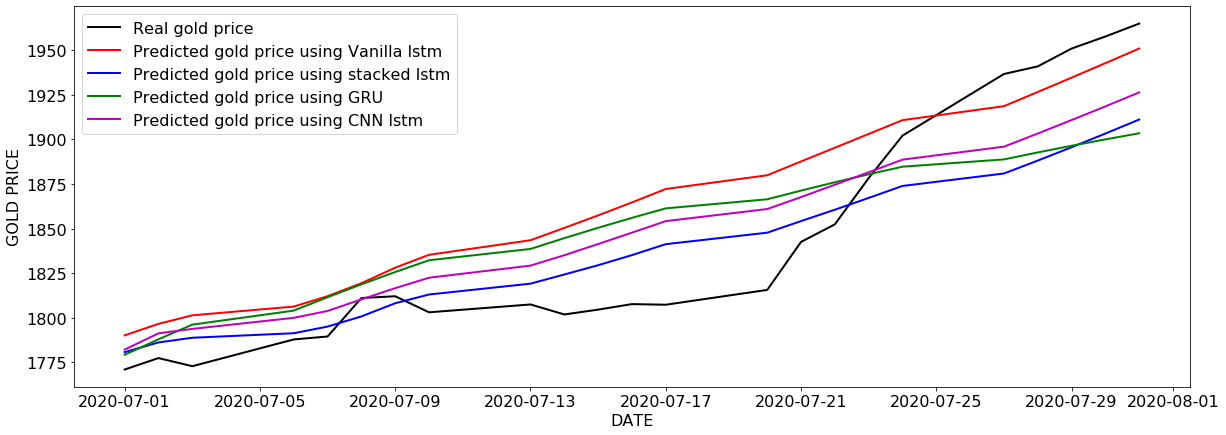

In [32]:
#creating plot

Y_vanilla=create_dataframe(y_vl,r_data,a_price)
Y_stacked=create_dataframe(y_sl,r_data,a_price)
Y_gru=create_dataframe(y_gru,r_data,a_price)
Y_cnn=create_dataframe(y_cn,r_data,a_price)
gold=pd.read_csv('gold_price.csv',parse_dates =["Date"], index_col ="Date")
real_data=gold.tail(r_data.size)
#print(real_data)
#print(Y_vanilla)
plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 16})
plt.plot(real_data, color = 'black',linewidth=2, label = 'Real gold price')
plt.plot(Y_vanilla, color = 'red',linewidth=2, label = 'Predicted gold price using Vanilla lstm')
plt.plot(Y_stacked, color = 'blue',linewidth=2, label = 'Predicted gold price using stacked lstm')
plt.plot(Y_gru, color = 'green', linewidth=2,label = 'Predicted gold price using GRU')
plt.plot(Y_cnn, color = 'm', linewidth=2,label = 'Predicted gold price using CNN lstm')
#plt.title('one day ahead gold price prediction using stacked LSTM')
plt.xlabel('DATE')
plt.ylabel('GOLD PRICE')
plt.legend()
plt.show()

In [33]:
#predicting one day ahead gold prices
y_gru=np.vstack(predict_1d(gru_gold,input_m,r_data,scaler))
y_vl=np.vstack(predict_1d(vl_gold,input_m,r_data,scaler))
y_sl=np.vstack(predict_1d(sl_gold,input_m,r_data,scaler))
y_cn=np.vstack(predict_1dcnn(cn_gold,input_m,r_data,scaler))

In [34]:
#getting rmse 
print("Vanilla lstm rmse=",rootms(r_data,y_vl))
print("Stacked lstm rmse=",rootms(r_data,y_sl))
print("GRU rmse=",rootms(r_data,y_gru))
print("CNN lstm rmse=",rootms(r_data,y_cn))

Vanilla lstm rmse= 27.521389813081267
Stacked lstm rmse= 30.29756530046136
GRU rmse= 13.853036247633936
CNN lstm rmse= 20.46664153154039


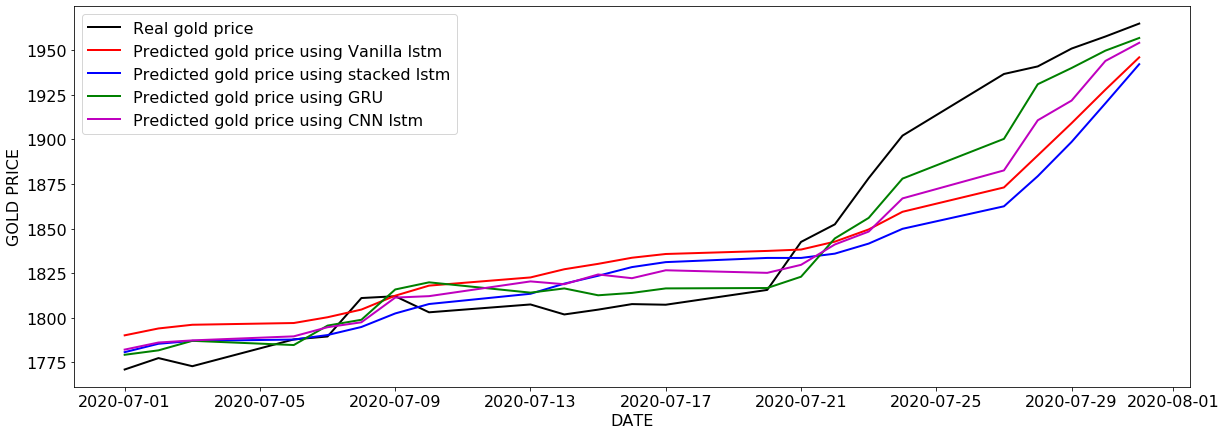

In [35]:
#creating plot
Y_vanilla=create_dataframe(y_vl,r_data,a_price)
Y_stacked=create_dataframe(y_sl,r_data,a_price)
Y_gru=create_dataframe(y_gru,r_data,a_price)
Y_cnn=create_dataframe(y_cn,r_data,a_price)
gold=pd.read_csv('gold_price.csv',parse_dates =["Date"], index_col ="Date")
real_data=gold.tail(r_data.size)
#print(real_data)
#print(Y_vanilla)
plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 16})
plt.plot(real_data, color = 'black',linewidth=2, label = 'Real gold price')
plt.plot(Y_vanilla, color = 'red',linewidth=2, label = 'Predicted gold price using Vanilla lstm')
plt.plot(Y_stacked, color = 'blue',linewidth=2, label = 'Predicted gold price using stacked lstm')
plt.plot(Y_gru, color = 'green', linewidth=2,label = 'Predicted gold price using GRU')
plt.plot(Y_cnn, color = 'm', linewidth=2,label = 'Predicted gold price using CNN lstm')
#plt.title('one day ahead gold price prediction using stacked LSTM')
plt.xlabel('DATE')
plt.ylabel('GOLD PRICE')
plt.legend()
plt.show()